In [1]:
import tensorflow as tf
from bayes_tec.bayes_opt.maximum_likelihood_tec import *
import numpy as np
float_type = tf.float64

def test_solve():
    
    import numpy as np
    from seaborn import jointplot
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.2,0.2,size=10000)#np.array([0.004]*1000)
    noise_rads = np.random.uniform(0.05,0.8,size=10000)#np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads[...,None]*np.random.normal(size=true_phase.shape)

    tec_min, phase_sigma = solve_ml_tec(phase,freqs)
    plt.scatter(true_tec,tec_min)
    plt.xlabel("True tec")
    plt.ylabel("Pred tec")
    plt.show()
   
    
    jointplot(true_tec,tec_min,kind='hex')
    plt.show()
    jointplot(true_tec,tec_min,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()
    
    plt.scatter(noise_rads, phase_sigma)
    plt.xlabel("Pred phase noise")
    plt.ylabel("True phase noise")
    plt.show()
    jointplot(noise_rads, phase_sigma,kind='hex')
    plt.show()
    jointplot(noise_rads, phase_sigma,kind='kde',alpha=0.6,marker='+',color='k')
    plt.show()

def diagnostics():
    
    import numpy as np
    import pylab as plt
    plt.style.use('ggplot')
    freqs = np.linspace(120e6,160e6,20)
    tec_conversion = -8.448e9/freqs
    true_tec = np.random.uniform(-0.3,0.3,size=1000)#np.array([0.004]*1000)
    noise_rads = np.array([0.3]*1000)# a lot of noise on almost flat TEC is hard
    true_phase = true_tec[...,None] * tec_conversion
    phase = true_phase + noise_rads[...,None]*np.random.normal(size=true_phase.shape)
    
    _tec = true_tec[0]
    
    with tf.Session(graph=tf.Graph()) as sess:
        t_pl = tf.placeholder(float_type)
        phase_pl = tf.placeholder(float_type)
        tec_conversion_pl = tf.placeholder(float_type)
        X_init, Y_init = init_population(phase_pl,tec_conversion_pl,N=5)
        Xcur, Ycur = X_init, Y_init
        X_,Y_,aq_,fmean_,fvar_ = [],[],[],[],[]
        for i in range(21):
            res = bayes_opt_iter(phase_pl, tec_conversion_pl, Xcur, Ycur, max_tec=0.4, t = t_pl)
            X_.append(res.X)
            Y_.append(res.Y)
            aq_.append(res.aq)
            fmean_.append(res.fmean)
            fvar_.append(res.fvar)
            Xcur = res.X
            Ycur = res.Y
        X, Y, aq, fmean, fvar = sess.run([X_, Y_, aq_, fmean_, fvar_], feed_dict={t_pl:1.,
                                                                         phase_pl:phase,
                                                                        tec_conversion_pl:tec_conversion})
        
        indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
        tec_min = X[-1][indices]
        plt.scatter(tec_min, true_tec)
        plt.xlabel("pred. tec")
        plt.ylabel("true tec")
        plt.title("Scatter of solutions")
        plt.show()

        plt.hist(indices[1],bins=20)
        plt.title("Where was fmin attained")
        plt.xlabel("iteration including random init pop")
        plt.show()

        scatter = []
        for j in range(Y[-1].shape[1]):
            indices = (np.arange(Y[-1].shape[0],dtype=np.int64), np.argmin(Y[-1][:,:j+1,0],axis=1), np.zeros(Y[-1].shape[0], dtype=np.int64))
            tec_j = X[-1][indices]
            scatter.append(np.percentile(np.abs(tec_j - true_tec),95))

        plt.plot(scatter)
        plt.title("95% conf interval of |true_tec - pred_tec|")
        plt.xlabel("iteration")
        plt.ylabel("mean delta tec")
        plt.show()


        tec_array = np.linspace(-0.4, 0.4, 100)
        for i, (x, y, a, f, v) in enumerate(zip(X, Y, aq, fmean, fvar)):
            y = y - y.mean(1,keepdims=True)
            y = y / (np.std(y,axis=1,keepdims=True) + 1e-6)
            
            
            plt.plot(tec_array, f[0,:], label=r'$\mathbb{E}[f]$')
            plt.fill_between(tec_array, f[0,:] - 2*np.sqrt(v[0,:]), f[0,:] + 2*np.sqrt(v[0,:]),alpha=0.5, label=r'$\pm 2\sigma_f$')
            a = a - np.min(a,axis=1,keepdims=True)
            a = 3*a/np.max(a,axis=1,keepdims=True)
            plt.plot(tec_array,a[0,:],label='norm. acquisition func.')
            plt.scatter(x[0, :-1, 0], y[0,:-1, 0],c='k',label='sampled points')
            plt.scatter(x[0, -1, 0], y[0,-1, 0],c='red',label='New sample point')
            plt.vlines(_tec,-2,2,label='global. min',linestyles='--')
            plt.xlabel("tec")
            plt.ylabel("normalized neg-log-likelihood")
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
            plt.title("Iteration {}".format(i))
            plt.show()
            

/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/rh/rh-python36/root/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'bayes_tec'

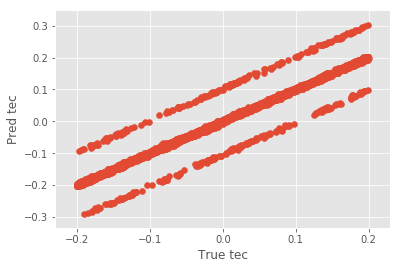

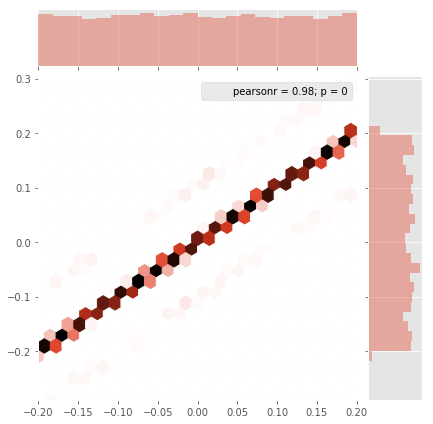

/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'marker'
  s)


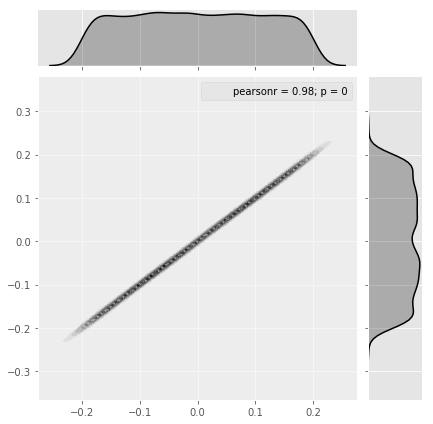

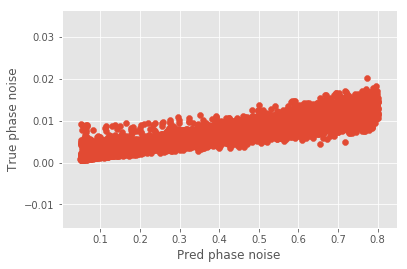

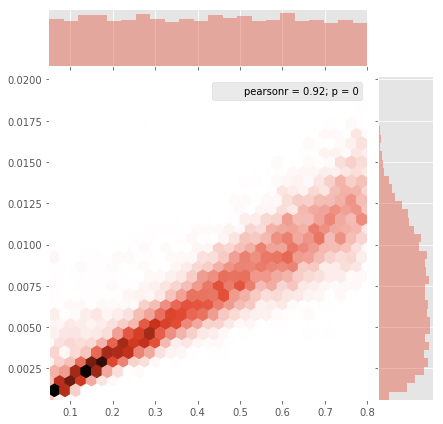

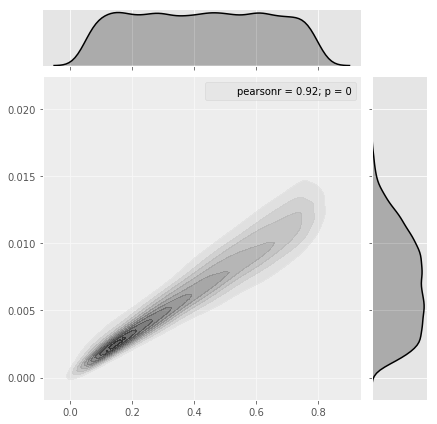

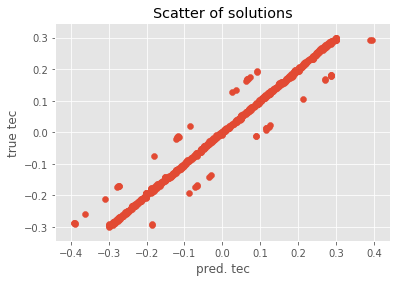

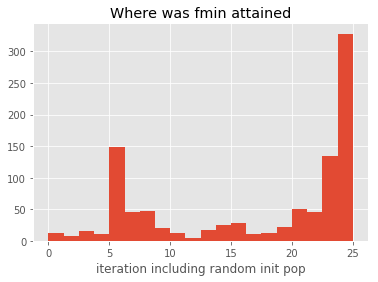

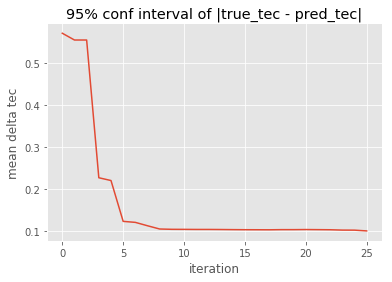

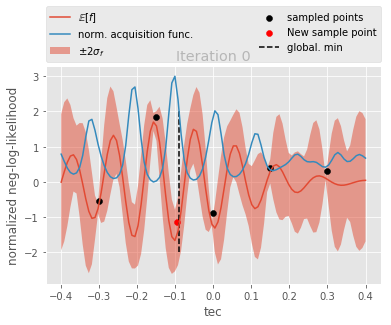

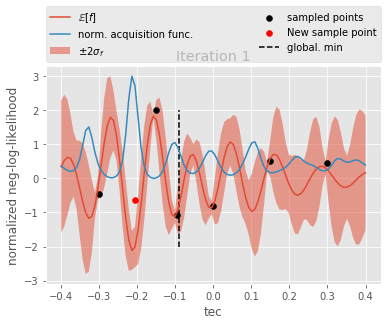

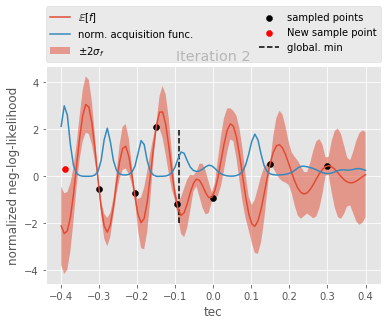

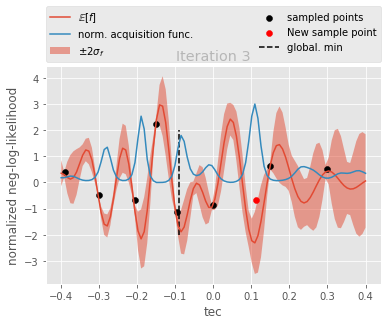

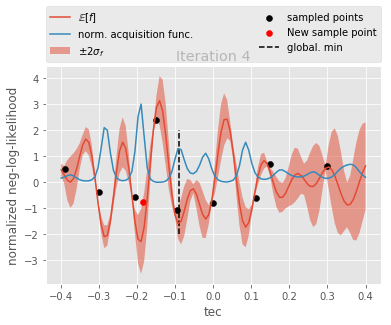

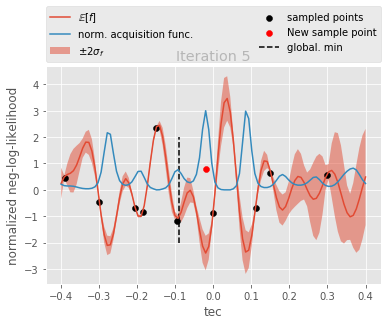

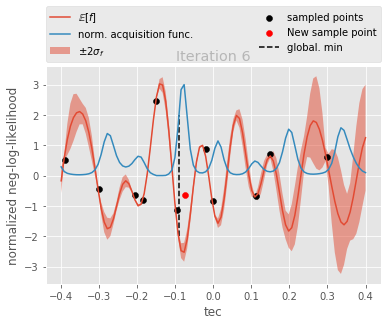

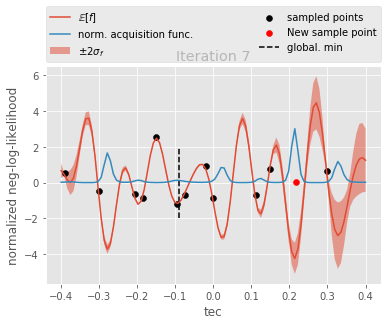

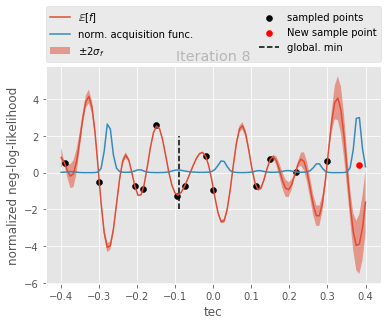

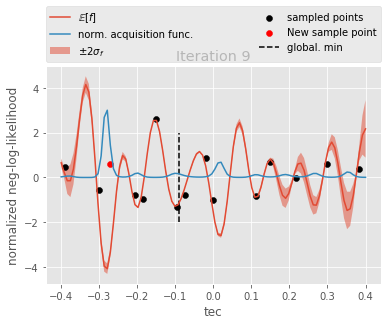

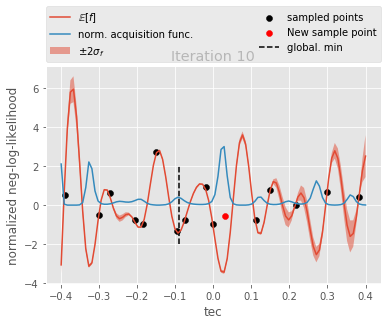

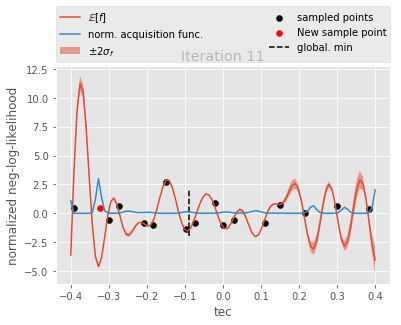

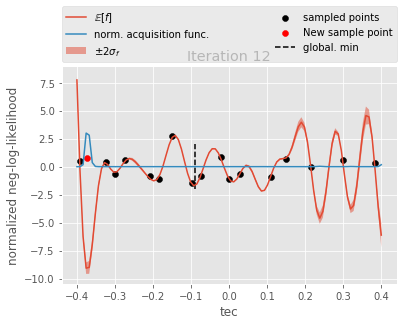

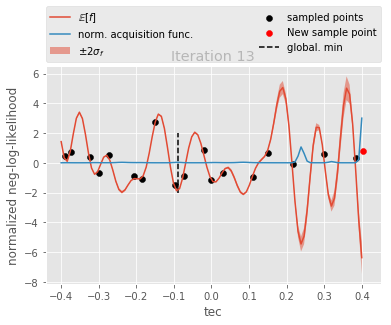

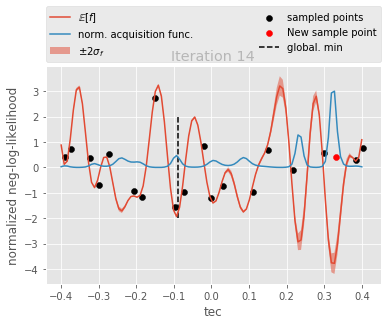

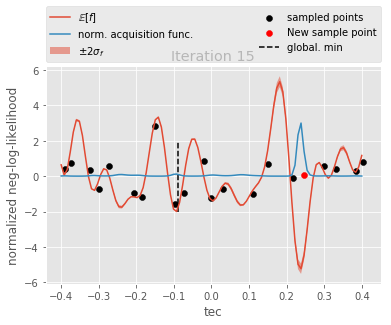

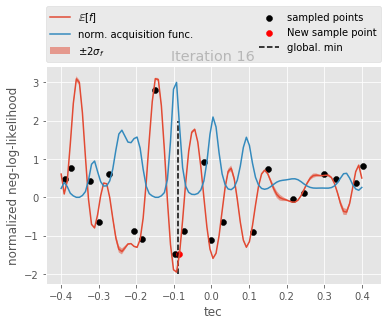

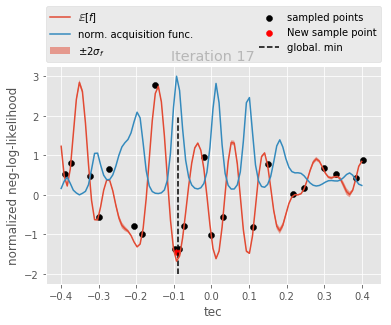

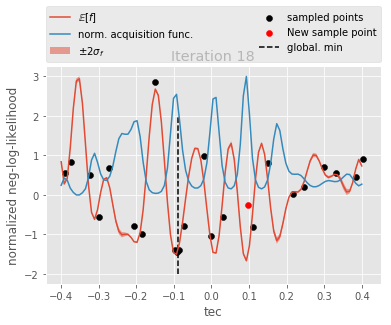

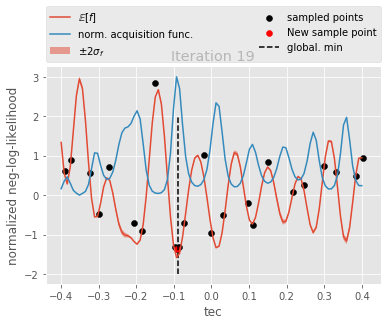

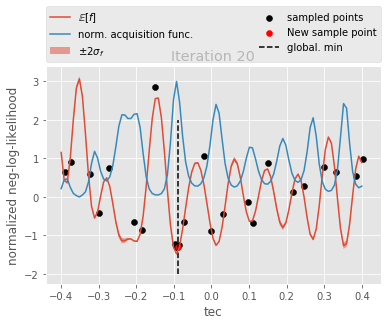

In [2]:
%matplotlib inline
test_solve()
diagnostics()

In [ ]:
from bayes_tec.datapack import DataPack
from timeit import default_timer
import h5py
from bayes_tec.bayes_opt.maximum_likelihood_tec import *

# with DataPack('../../scripts/data/killms_datapack.hdf5') as datapack:
#     datapack.select(ant='RS205HBA',time=slice(0,10,1))
#     phase,axes = datapack.phase
#     weights, axies = datapack.weights_phase
#     _, freqs = datapack.get_freqs(axes['freq'])
#     Npol, Nd, Na, Nf, Nt = phase.shape
#     phase = phase.transpose((0,1,2,4,3))
#     phase = phase.reshape((-1, Nf))
#     tec_ml, sigma_ml = solve_ml_tec(phase, freqs, batch_size=int(1e5),max_tec=0.4, n_iter=30, t=1.,num_proposal=100, verbose=True)
#     tec_ml = tec_ml.reshape((Npol, Nd, Na, Nt))
#     sigma_ml = sigma_ml.reshape((Npol, Nd, Na, Nt))   
    
with DataPack('../../scripts/data/killms_datapack.hdf5') as datapack:
#     datapack.select_all()
#     axes = datapack.axes_phase
#     timestamps, times = datapack.get_times(axes['time'])
#     pol_labels, pols = datapack.get_pols(axes['pol'])
#     datapack.delete_soltab('tec_test')
#     datapack.add_freq_indep_tab('tec_test', times.mjd*86400., pols = pol_labels)
#     tec, axes = datapack.tec

    datapack.select(pol=slice(0,1,1))

    phase,axes = datapack.phase
    _, freqs = datapack.get_freqs(axes['freq'])

    Npol, Nd, Na, Nf, Nt = phase.shape
    phase = phase.transpose((0,1,2,4,3))
    phase = phase.reshape((-1, Nf))
    tec_ml, sigma_ml = solve_ml_tec(phase, freqs, batch_size=int(1e6),max_tec=0.4, n_iter=26, t=2.0,num_proposal=100, verbose=True)
    tec_ml = tec_ml.reshape((Npol, Nd, Na, Nt))
    sigma_ml = sigma_ml.reshape((Npol, Nd, Na, Nt))
    with h5py.File('./killms_ml.hdf5') as f:
        f['tec'] = tec_ml
        f['sigma_ml'] = sigma_ml
#     tec,axes = datapack.tec
#     print(tec.shape)
#     print(tec_ml.shape)
#     #print(np.square(sigma_ml))
#     print(np.square(sigma_ml).shape)

2018-09-17 10:17:12,267 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-17 10:17:12,272 Closing table.
2018-09-17 10:17:12,274 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-17 10:17:37,119 Starting batch 0


In [ ]:
from bayes_tec.datapack import DataPack
import numpy as np
import h5py

with h5py.File('./killms_ml.hdf5') as f:
    tec_ml = f['tec'][...]
    sigma_ml = f['sigma_ml'][...]
    
def wrap(phi):
    return np.angle(np.exp(1j*phi))

with DataPack('../../scripts/data/killms_datapack_3.hdf5') as datapack:
    datapack.select_all()
    axes = datapack.axes_phase
    timestamps, times = datapack.get_times(axes['time'])
    pol_labels, pols = datapack.get_pols(axes['pol'])
    _, freqs = datapack.get_freqs(axes['freq'])
    datapack.delete_soltab('tec')
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)
    
    var_ml = np.tile(np.square(sigma_ml),(4,1,1,1))
    datapack.tec = np.tile(tec_ml,(4,1,1,1))
    datapack.weights_tec = 1./var_ml
    tec, axes = datapack.tec
    tec_var, _ = datapack.weights_tec
    phase,_ = datapack.phase
    ml_phase = tec_ml[...,None,:]*-8.4480e9/freqs[:,None]
    dphase = np.abs(wrap(wrap(phase) - wrap(ml_phase)))
    datapack.weights_phase = 1./dphase**2
    phase_var, _ = datapack.weights_phase


2018-09-18 01:58:26,062 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-09-18 01:58:26,096 Closing table.
2018-09-18 01:58:26,106 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_3.hdf5.
2018-09-18 01:58:26,318 Soltab "tec000" deleted.
2018-09-18 01:58:26,835 Creating a new solution-table: tec000.


/net/lofar1/data1/albert/miniconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
from bayes_tec.plotting.plot_datapack import plot_data_vs_solution

plot_data_vs_solution('../../scripts/data/ndpp_datapack.hdf5','figs_ml_ndppp',solution_solset='sol000',ant_sel='RS210HBA',pol_sel=slice(0,1,1),time_sel=slice(0,None,1),freq_sel=slice(12,13,1))


2018-09-17 15:49:28,403 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-17 15:49:28,409 Closing table.
2018-09-17 15:49:28,411 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack.hdf5.
2018-09-17 15:49:29,332 Closing table.


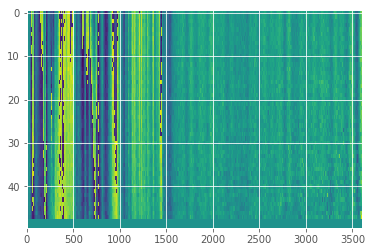

In [8]:
from bayes_tec.datapack import DataPack

with DataPack('../../scripts/data/killms_datapack.hdf5') as datapack:
    datapack.select(ant='RS210HBA')
    phase,axes = datapack.phase

import pylab as plt
plt.imshow(phase[0,11,0,:,:],aspect='auto')
plt.show()

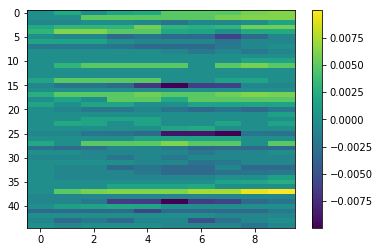

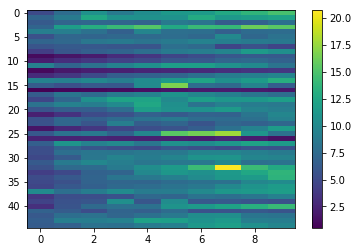

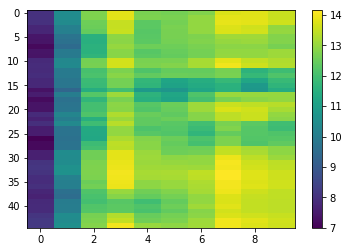

In [62]:
import pylab as plt
plt.imshow(tec_ml[0,:,0,:],aspect='auto')
plt.colorbar()
plt.show()

plt.imshow(sigma_ml[0,:,0,:]*8.448e9/140e6*180./np.pi,aspect='auto')
plt.colorbar()
plt.show()

yvar = 1./np.sqrt(weights) 
yvar = yvar[0,:,0,12,:]*180./np.pi
plt.imshow(yvar.astype(np.float32),aspect='auto')
plt.colorbar()
plt.show()


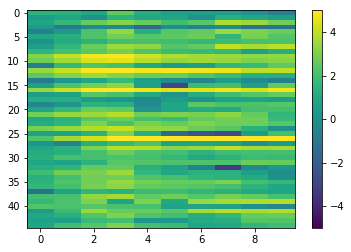

In [63]:
%matplotlib inline 

yvar = 1./np.sqrt(weights) 
yvar = (yvar[0,:,0,12,:]*180./np.pi - sigma_ml[0,:,0,:]*8.448e9/140e6*180./np.pi)/2.
plt.imshow(yvar.astype(np.float32),aspect='auto',vmin=-5, vmax=5)
plt.colorbar()
plt.show()

In [45]:
(yvar[0,:,0,12,:]*180./np.pi).dtype

dtype('float16')